## 0. Environment check
We confirm the notebook is using the project's virtual environment (`.venv`).  
If the path below does not point into `model_validation/.venv`, select the correct kernel.

In [1]:
import sys
print(sys.executable)


c:\Users\Renee\Documents\Python\model_validation\.venv\Scripts\python.exe


If the path ends with `model_validation/.venv/Scripts/python.exe`, we're good.  
Otherwise: Kernel → Select → pick the `.venv` interpreter.



## 1. Setup and data load
Import core libraries and load the synthetic dataset we generated.  
We do a quick size + target-rate check and peek at the first rows.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path   # ✅ built-in, no need to pip install

# Point to the data folder (relative to the notebooks directory)
data_dir = Path("../data")

# Find the latest file by modification time
latest_file = max(data_dir.glob("sample_data_*.csv"), key=lambda f: f.stat().st_mtime)
print("Loading:", latest_file)

# Load into DataFrame
df = pd.read_csv(latest_file)

print("Shape:", df.shape)
print("Default rate: {:.2f}%".format(df["default"].mean()*100))
df.head()


Shape: (900000, 9)
Default rate: 7.02%


,age,income,loan_amount,loan_term,credit_score,employment_status,loan_purpose,region,default
0,59,6216,1194,36,641,Unemployed,Home,Tartu,0
1,49,2474,6849,12,724,Self-employed,Home,Tartu,0
2,35,2686,16405,36,423,Employed,Car,Narva,0
3,63,4434,21969,36,527,Employed,Small Business,Narva,0
4,28,2320,31628,24,646,Employed,Other,Pärnu,0


We expect ~900k rows, 9 columns, and a ~7% default rate.  
A quick glance at the head confirms the expected schema.


## 2. Data overview
We inspect types, basic statistics, and missing values to ensure cleanliness.


In [3]:
df.info()
display(df.describe().T)
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   age                900000 non-null  int64 
 1   income             900000 non-null  int64 
 2   loan_amount        900000 non-null  int64 
 3   loan_term          900000 non-null  int64 
 4   credit_score       900000 non-null  int64 
 5   employment_status  900000 non-null  object
 6   loan_purpose       900000 non-null  object
 7   region             900000 non-null  object
 8   default            900000 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 61.8+ MB


,count,mean,std,min,25%,50%,75%,max
age,900000.0,45.007193,14.138675,21.0,33.0,45.0,57.0,69.0
income,900000.0,4424.152980,2222.525833,562.0,2569.0,4260.0,6061.0,10491.0
loan_amount,900000.0,20502.658197,11254.334116,1000.0,10749.0,20526.0,30237.0,39999.0
loan_term,900000.0,38.408827,14.989598,12.0,24.0,36.0,48.0,60.0
credit_score,900000.0,575.042564,159.013683,300.0,437.0,575.0,713.0,850.0
default,900000.0,0.070188,0.255463,0.0,0.0,0.0,0.0,1.0


age                  0
income               0
loan_amount          0
loan_term            0
credit_score         0
employment_status    0
loan_purpose         0
region               0
default              0
dtype: int64

All columns are non-null. Numeric ranges look reasonable; categoricals are strings (`object`).  
No imputation needed at this stage.


## 3. Target balance
Check whether `default` is imbalanced. Strong imbalance can affect model training and metrics.


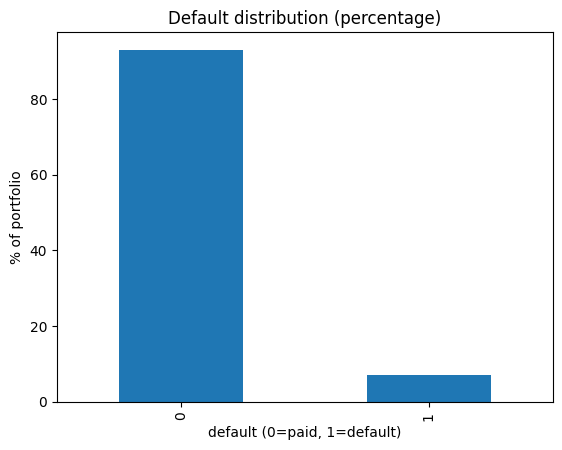

default
0    92.98
1     7.02
Name: proportion, dtype: float64


In [4]:
ax = (df["default"].value_counts(normalize=True)
      .sort_index()
      .mul(100)
      .plot(kind="bar"))
ax.set_title("Default distribution (percentage)")
ax.set_xlabel("default (0=paid, 1=default)")
ax.set_ylabel("% of portfolio")
plt.show()

print(df["default"].value_counts(normalize=True).mul(100).round(2))


We aim for ~7% defaults (class 1). This is realistic for consumer credit and good for modeling.


## 4. Univariate distributions (numeric)
Visualize distributions to spot skewness/outliers and understand scale.


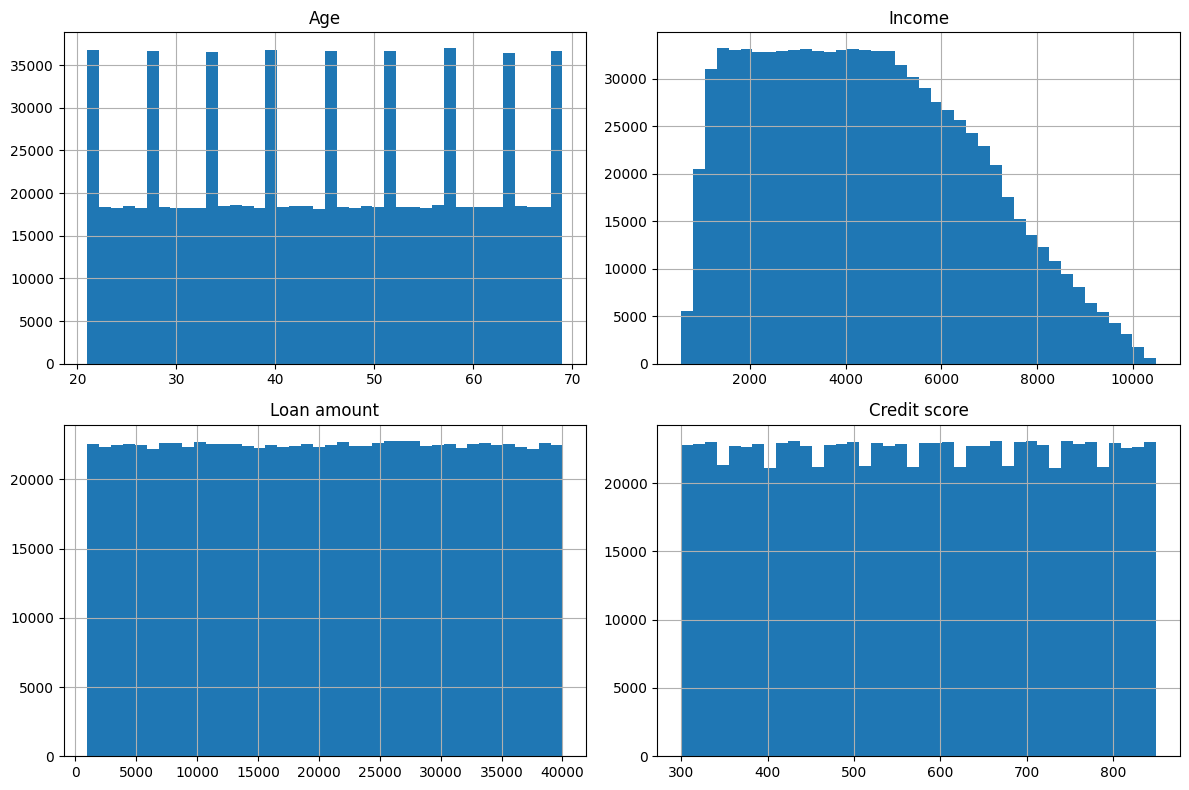

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df["age"].hist(bins=40, ax=axes[0,0]);         axes[0,0].set_title("Age")
df["income"].hist(bins=40, ax=axes[0,1]);      axes[0,1].set_title("Income")
df["loan_amount"].hist(bins=40, ax=axes[1,0]); axes[1,0].set_title("Loan amount")
df["credit_score"].hist(bins=40, ax=axes[1,1]);axes[1,1].set_title("Credit score")

plt.tight_layout(); plt.show()


Distributions look sensible for synthetic data. If we saw extreme spikes or empty ranges, we’d revisit the generator.


## 5. Default rates by category
Group by each categorical feature to see which segments carry higher risk.


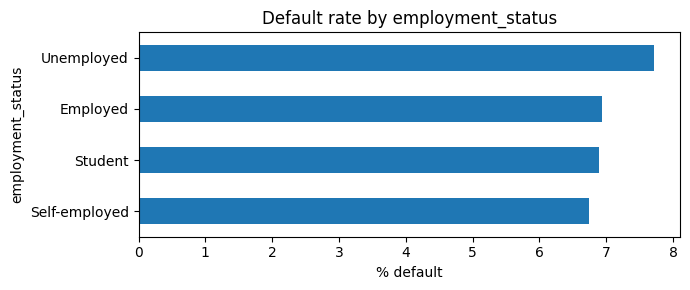

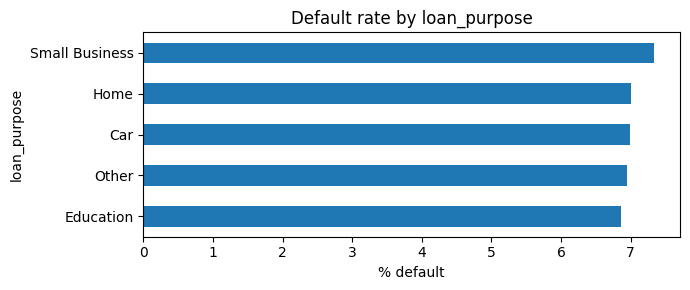

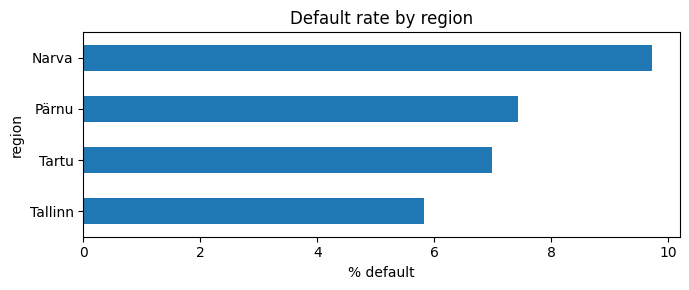

In [6]:
cats = ["employment_status", "loan_purpose", "region"]
for col in cats:
    rate = pd.crosstab(df[col], df["default"], normalize="index")[1].sort_values()
    ax = rate.mul(100).plot(kind="barh", figsize=(7, 3), title=f"Default rate by {col}")
    ax.set_xlabel("% default")
    plt.tight_layout()
    plt.show()


We expect higher risk for *Unemployed* and *Small Business*, and region uplift in Narva by design.  
These patterns confirm the data generator is producing intuitive signals.


## 6. Credit score vs default
Lower scores should align with higher default incidence.


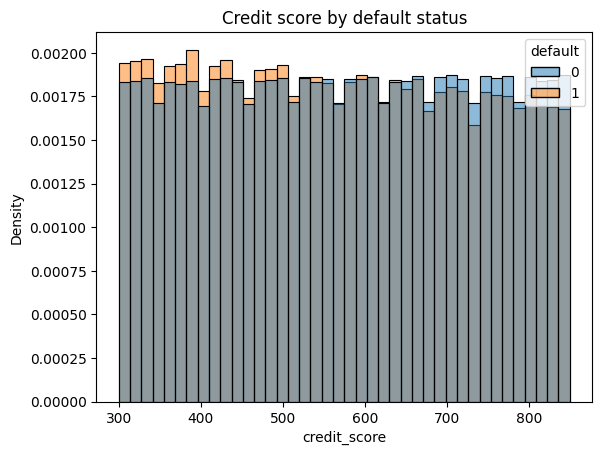

In [7]:
sns.histplot(data=df, x="credit_score", hue="default",
             bins=40, stat="density", common_norm=False)
plt.title("Credit score by default status")
plt.show()


Separation between classes across score range indicates useful predictive signal.


## 7. Correlation analysis (numeric)
Quick correlation scan to identify the strongest numerical drivers.


default         1.000000
loan_amount     0.129302
loan_term       0.003432
age            -0.000802
credit_score   -0.011559
income         -0.138745
Name: default, dtype: float64

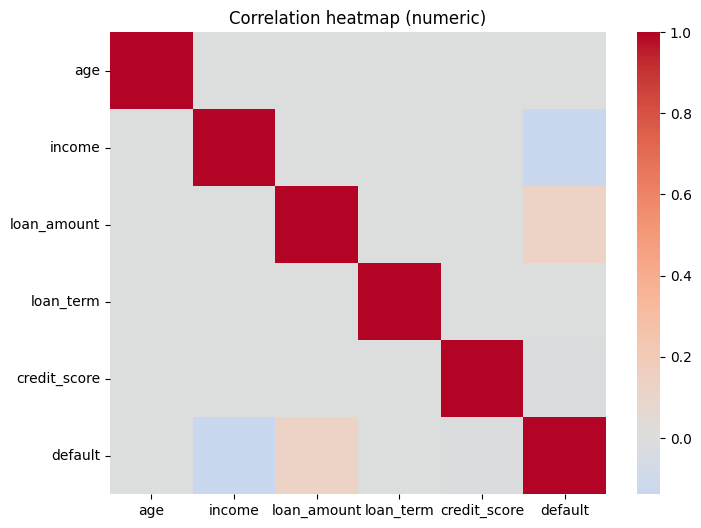

In [8]:
num_cols = ["age", "income", "loan_amount", "loan_term", "credit_score", "default"]
corr = df[num_cols].corr()
display(corr["default"].sort_values(ascending=False))

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric)")
plt.show()


Expect negative correlation between credit_score and default, positive between loan_amount/income ratio (proxy: loan_amount) and default.
Correlations are directional hints; model training will capture non-linearities and interactions.


## 8. (Optional) Feature engineering preview
Create a simple proxy for leverage: loan_amount / income. This often has strong signal.


In [9]:
df["loan_to_income"] = df["loan_amount"] / (df["income"] + 1)
df["loan_to_income"].describe()


count    900000.000000
mean          6.560883
std           6.480513
min           0.098129
25%           2.429966
50%           4.662755
75%           8.189969
max          68.259005
Name: loan_to_income, dtype: float64

We’ll likely use `loan_to_income`, one-hot encoded categoricals, and scaled numerics for the logistic regression next.
